In [1]:
from io import open
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)

In [3]:
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [4]:
glob.glob('data/names/*.txt')

['data/names/Czech.txt',
 'data/names/German.txt',
 'data/names/Arabic.txt',
 'data/names/Japanese.txt',
 'data/names/Chinese.txt',
 'data/names/Vietnamese.txt',
 'data/names/Russian.txt',
 'data/names/French.txt',
 'data/names/Irish.txt',
 'data/names/English.txt',
 'data/names/Spanish.txt',
 'data/names/Greek.txt',
 'data/names/Italian.txt',
 'data/names/Portuguese.txt',
 'data/names/Scottish.txt',
 'data/names/Dutch.txt',
 'data/names/Korean.txt',
 'data/names/Polish.txt']

In [5]:
import unicodedata
import string

In [6]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [8]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [9]:
category_lines = {}
all_categories = []

In [10]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [11]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [12]:
n_categories = len(all_categories)
n_categories

18

In [13]:
print(category_lines['Arabic'][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


# Turn to Tensors

In [14]:
import torch

In [18]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [30]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [35]:
print(lineToTensor('Pepe').size())

torch.Size([4, 1, 57])


In [36]:
print(lineToTensor('Pepe'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

# RNN

In [37]:
import torch.nn as nn
import torch.nn.functional as F

In [38]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [39]:
n_hidden = 128

In [49]:
# Instanciar el modelo RNN
rnn = RNN(n_letters, n_hidden, n_categories)

**Test**

In [64]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

# Pass the first value of the line
output, next_hidden = rnn(input[0], hidden)

In [65]:
print(output)

tensor([[-3.0033, -2.9838, -2.9115, -2.8890, -2.9430, -2.8366, -2.8707, -2.8464,
         -2.8044, -2.8789, -2.8685, -2.8381, -2.9692, -2.8830, -2.9276, -2.8393,
         -2.8448, -2.9153]], grad_fn=<LogSoftmaxBackward0>)


In [67]:
output.shape

torch.Size([1, 18])

In [73]:
top_n, top_i = output.topk(1)
print(top_n.item(), top_i.item())

-2.80441951751709 8


In [74]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()

    return all_categories[category_i], category_i

In [75]:
print(categoryFromOutput(output))

('Irish', 8)


In [76]:
import random

In [80]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Sztegon
category = Russian / line = Tulov
category = Korean / line = Seo
category = Irish / line = Duncan
category = Czech / line = Antonowitsch
category = English / line = Furniss
category = Dutch / line = Achthoven
category = Irish / line = Daly
category = French / line = Denis
category = Arabic / line = Tahan


In [81]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [83]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [84]:
import time
import math

In [85]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [86]:
current_loss = 0
all_losses = []

In [87]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [88]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.0643 Tsang / Chinese ✓
10000 10% (0m 5s) 1.2314 Beckenbauer / German ✓
15000 15% (0m 8s) 1.5793 Mansour / French ✗ (Arabic)
20000 20% (0m 10s) 1.0149 Zabek / Polish ✓
25000 25% (0m 13s) 0.9303 Bobienski / Polish ✓
30000 30% (0m 16s) 0.1456 Rossini / Italian ✓
35000 35% (0m 18s) 1.3190 Garcia / Arabic ✗ (Portuguese)
40000 40% (0m 21s) 0.7793 Luo / Chinese ✓
45000 45% (0m 23s) 0.3534 Weber / German ✓
50000 50% (0m 26s) 1.1977 Li / Vietnamese ✗ (Korean)
55000 55% (0m 28s) 2.7862 Molcan / Irish ✗ (Czech)
60000 60% (0m 30s) 1.0144 Yang / Korean ✗ (Chinese)
65000 65% (0m 33s) 0.6116 Escarcega / Spanish ✓
70000 70% (0m 36s) 0.5479 Dziadik / Czech ✓
75000 75% (0m 39s) 3.5370 Salazar / Arabic ✗ (Spanish)
80000 80% (0m 41s) 1.0016 Botros / Arabic ✓
85000 85% (0m 44s) 0.0818 Meadhra / Irish ✓
90000 90% (0m 47s) 0.4921 Donk / Dutch ✓
95000 95% (0m 50s) 1.2288 Ding / Vietnamese ✗ (Chinese)
100000 100% (0m 52s) 0.1012 Tchekhoev / Russian ✓


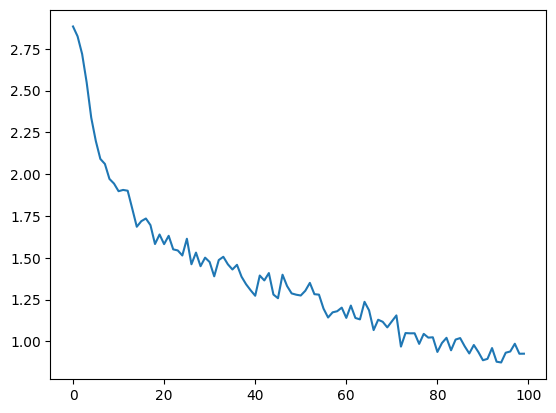

In [90]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

# Evaluation

/var/folders/pc/mkcyyvhd0vggcpltg8x7prb80000gn/T/ipykernel_69811/3597697864.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/pc/mkcyyvhd0vggcpltg8x7prb80000gn/T/ipykernel_69811/3597697864.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


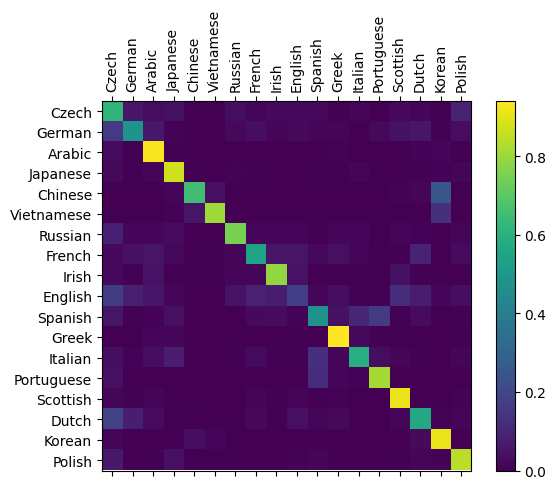

In [91]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Predict

In [92]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [98]:
predict('Mathias')
predict('Nataly')
predict('Walter')


> Mathias
(-1.08) Greek
(-1.10) Arabic
(-2.44) Irish

> Nataly
(-0.52) Irish
(-1.11) Arabic
(-3.43) English

> Walter
(-1.27) Polish
(-1.39) German
(-1.46) Scottish
